In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [3]:
CSV_PATH = './2025-grievances.csv'
SEQUENCE_LENGTH = 30
MIN_SAMPLES = 80
TF_RANDOM_SEED = 42
np.random.seed(0)
tf.random.set_seed(TF_RANDOM_SEED)

In [4]:
problem_types = [
    'Street Light Not Working',
    'Garbage dumping in vacant sites',
    'Potholes',
    'Garbage dump',
    'Others',
    'water stagnation',
    'Cleanliness'
]



In [5]:
df = pd.read_csv(CSV_PATH, usecols=['Sub Category', 'Grievance Date'])
df['Grievance Date'] = pd.to_datetime(df['Grievance Date'])
df = df[df['Sub Category'].isin(problem_types)]

MODEL_CACHE = {}

In [6]:
def prepare_daily_data(df_sub: pd.DataFrame):
    daily = df_sub.groupby(df_sub["Grievance Date"].dt.date).size().reset_index(name='count')
    daily['date'] = pd.to_datetime(daily['Grievance Date'])
    daily = daily[['date', 'count']]
    full_range = pd.date_range(daily['date'].min(), daily['date'].max(), freq='D')
    daily = daily.set_index('date').reindex(full_range, fill_value=0).rename_axis('date').reset_index()

    daily['month'] = daily['date'].dt.month
    daily['month_sin'] = np.sin(2 * np.pi * daily['month'] / 12)
    daily['month_cos'] = np.cos(2 * np.pi * daily['month'] / 12)
    daily['dayofweek'] = daily['date'].dt.dayofweek
    daily['dow_sin'] = np.sin(2 * np.pi * daily['dayofweek'] / 7)
    daily['dow_cos'] = np.cos(2 * np.pi * daily['dayofweek'] / 7)
    daily['is_festival'] = 0
    daily['is_holiday'] = 0
    np.random.seed(0)
    daily['rain_mm'] = np.random.gamma(3, 4, size=len(daily))
    daily['count_lag1'] = daily['count'].shift(1).fillna(0)
    daily['count_lag2'] = daily['count'].shift(2).fillna(0)
    daily['log_count'] = np.log1p(daily['count'])
    daily['count_lag7'] = daily['count'].shift(7).fillna(0)
    daily['count_rolling_max7'] = daily['count'].rolling(7, min_periods=1).max().shift(1).fillna(0)
    daily['count_rolling_sum7'] = daily['count'].rolling(7, min_periods=1).sum().shift(1).fillna(0)

    features = [
        'count', 'count_lag1', 'count_lag2', 'count_lag7',
        'count_rolling_max7', 'count_rolling_sum7',
        'month_sin', 'month_cos', 'dow_sin', 'dow_cos',
        'is_festival', 'is_holiday', 'rain_mm'
    ]
    return daily, features

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)


In [7]:
for problem in problem_types:
    df_sub = df[df['Sub Category'] == problem]
    if df_sub.empty:
        MODEL_CACHE[problem] = {"error": "No data available"}
        continue

    daily, features = prepare_daily_data(df_sub)
    X_all = daily[features].values.astype(float)
    y_all = daily['log_count'].values.astype(float)

    X_seq, y_seq = create_sequences(X_all, y_all, SEQUENCE_LENGTH)
    if len(X_seq) < MIN_SAMPLES:
        MODEL_CACHE[problem] = {"error": "Not enough data"}
        continue

    split = int(0.8 * len(X_seq))
    X_train, y_train = X_seq[:split], y_seq[:split]

    f_scaler = MinMaxScaler()
    X_train_scaled = f_scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)

    t_scaler = MinMaxScaler()
    y_train_scaled = t_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()

    tf.random.set_seed(TF_RANDOM_SEED)
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
        LSTM(64, return_sequences=True),
        Dropout(0.12),
        LSTM(32),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mae')
    es = EarlyStopping(patience=10, restore_best_weights=True)
    model.fit(X_train_scaled, y_train_scaled, epochs=5, batch_size=8, verbose=0, callbacks=[es])

    MODEL_CACHE[problem] = {
        "model": model,
        "f_scaler": f_scaler,
        "t_scaler": t_scaler,
        "features": features,
        "daily": daily
    }

d:\Projects\HACKATHONS\SIH\ML\myenv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
d:\Projects\HACKATHONS\SIH\ML\myenv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
d:\Projects\HACKATHONS\SIH\ML\myenv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
d:\Projects\HACKATHONS\SIH\ML\myenv\Lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


In [8]:
user_date = input("Enter prediction date (YYYY-MM-DD): ")
try:
    user_date = pd.to_datetime(user_date)
except:
    raise ValueError("Invalid date format. Use YYYY-MM-DD.")

In [9]:
results = []
for problem, entry in MODEL_CACHE.items():
    if "error" in entry:
        results.append({"problem": problem, "predicted_percentage": None, "error": entry["error"]})
        continue

    model = entry["model"]
    daily = entry["daily"].copy()
    features = entry["features"]
    f_scaler = entry["f_scaler"]
    t_scaler = entry["t_scaler"]

    # Extend daily data until user_date
    while daily['date'].iloc[-1] < user_date:
        next_date = daily['date'].iloc[-1] + pd.Timedelta(days=1)
        next_row = daily.iloc[-1:].copy()
        next_row['date'] = next_date
        next_row['count'] = 0
        daily = pd.concat([daily, next_row], ignore_index=True)

        # recompute features
        daily['month'] = daily['date'].dt.month
        daily['month_sin'] = np.sin(2 * np.pi * daily['month'] / 12)
        daily['month_cos'] = np.cos(2 * np.pi * daily['month'] / 12)
        daily['dayofweek'] = daily['date'].dt.dayofweek
        daily['dow_sin'] = np.sin(2 * np.pi * daily['dayofweek'] / 7)
        daily['dow_cos'] = np.cos(2 * np.pi * daily['dayofweek'] / 7)
        daily['count_lag1'] = daily['count'].shift(1).fillna(0)
        daily['count_lag2'] = daily['count'].shift(2).fillna(0)
        daily['count_lag7'] = daily['count'].shift(7).fillna(0)
        daily['count_rolling_max7'] = daily['count'].rolling(7, min_periods=1).max().shift(1).fillna(0)
        daily['count_rolling_sum7'] = daily['count'].rolling(7, min_periods=1).sum().shift(1).fillna(0)
        daily['log_count'] = np.log1p(daily['count'])

        X_all = daily[features].values.astype(float)
        last_seq = X_all[-SEQUENCE_LENGTH:]
        last_seq_scaled = f_scaler.transform(last_seq)
        pred_scaled = model.predict(last_seq_scaled[np.newaxis, :, :], verbose=0)[0, 0]
        pred_log = t_scaler.inverse_transform([[pred_scaled]])[0, 0]
        pred_count = np.expm1(pred_log)
        daily.loc[daily['date'] == next_date, 'count'] = pred_count

    pred_value = daily.loc[daily['date'] == user_date, 'count'].values[0]
    results.append({
        "problem": problem,
        "predicted_complaints": max(pred_value, 0)  # avoid negative
    })

results_df = pd.DataFrame(results)
total = results_df["predicted_complaints"].sum()
results_df["predicted_percentage"] = (results_df["predicted_complaints"] / total * 100).round(2)

display(results_df[["problem", "predicted_percentage"]])


C:\Users\nirvi\AppData\Local\Temp\ipykernel_23540\1832612470.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '230.90350915156853' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  daily.loc[daily['date'] == next_date, 'count'] = pred_count
C:\Users\nirvi\AppData\Local\Temp\ipykernel_23540\1832612470.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.411057173922805' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  daily.loc[daily['date'] == next_date, 'count'] = pred_count
C:\Users\nirvi\AppData\Local\Temp\ipykernel_23540\1832612470.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '40.34120342485363' has dtype incompatible with int64, please explicitly

,problem,predicted_percentage
0,Street Light Not Working,19.71
1,Garbage dumping in vacant sites,0.00
2,Potholes,4.41
3,Garbage dump,1.35
4,Others,0.14
5,water stagnation,74.38
6,Cleanliness,0.02


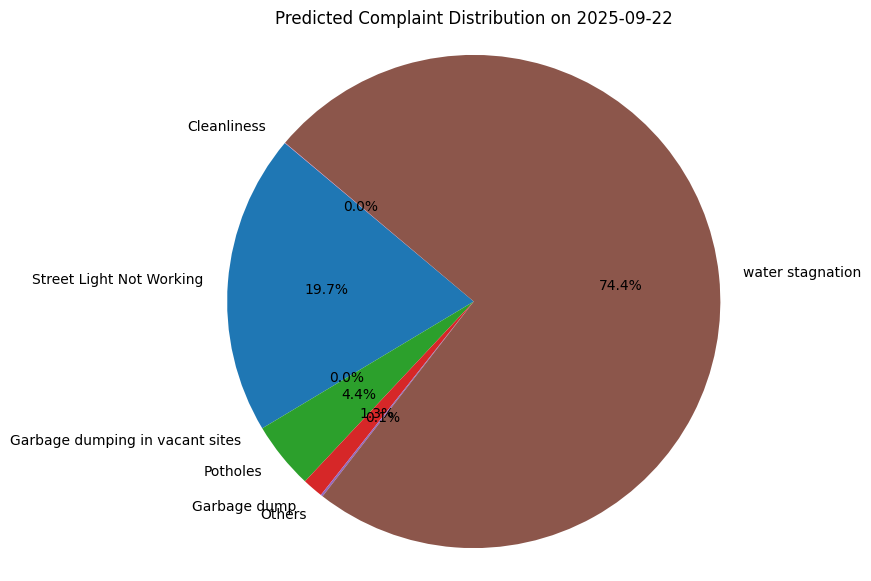

In [10]:
plt.figure(figsize=(7, 7))
plt.pie(
    results_df["predicted_percentage"],
    labels=results_df["problem"],
    autopct='%1.1f%%',
    startangle=140
)
plt.title(f"Predicted Complaint Distribution on {user_date.date()}")
plt.axis('equal')
plt.show()